In [3]:
from utils import *

import numpy as np 
import pandas as pd 
from sklearn import model_selection
import keras
from keras import Model
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
import glob

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

Using TensorFlow backend.


In [0]:
#Connessione a Google Drive, rende possibile accedere a file e cartelle contenuti in 'Il mio Drive' 
#Eseguire solo se i dataset sono salvati non in locale ma in Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparazione dati

In [0]:
#Utilizzato per caricare batch di dati di volta in volta senza dover salvare l'intero dataset in una variabile, permette operazioni di
#data-augmentation in tempo reale.
#E' stata utilizzata una versione modificata di ImageDataGenerator adattata per il multi-label

datagen = ImageDataGenerator(
              width_shift_range=0.2,
              height_shift_range=0.2,
              rescale=1./255,
              shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True,
              fill_mode='nearest')

datagenValidation = ImageDataGenerator(rescale=1./255)

In [0]:
train_batch_size = 20
valid_batch_size = 20
tg_size = (299,299)

#Definito il percorso al dataset utilizza ImageDataGenerator per raccogliere una quantità di immagini pari a 'batch_size'. 
#Viene effettuato il resize e mescolati i dati

train_generator = datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/train_multi/",
    target_size=tg_size,
    color_mode="rgb",
    batch_size=train_batch_size,
    class_mode="multi_categorical",
    shuffle=True,
    seed=4242
)

validation_generator = datagenValidation.flow_from_directory(
    directory=r"/content/drive/My Drive/val_splitted/",
    target_size=tg_size,
    color_mode="rgb",
    batch_size=valid_batch_size,
    class_mode="multi_categorical",
    shuffle=True,
    seed=4242
)

Found 5717 images belonging to 254 classes containing 234 multi classes.
Found 5007 images belonging to 231 classes containing 211 multi classes.


# Definizione modello e addesstramento

In [0]:
#InceptionV3
#Il modello utilizzato è basato sulla rete InceptionV3 pre-addestrata su dataset 'imagenet'.
#E' stato eseguita un'operazione di fine-tuning rimuovendo il layer di output e aggiunti tre layer: due fully connected di cui uno da 512 neuroni
#ed uno di output da 20 (20 classi) e nel mezzo un layer di Dropout. 
#Solo i layer aggiunti sono addestrabili.

base_model = InceptionV3(include_top=True,weights='imagenet',input_shape=(299, 299, 3))
base_model.layers.pop()

for layer in base_model.layers:
    layer.trainable = False
    

x = Dense(512, activation = 'relu')(base_model.layers[-1].output)
x = Dropout(0.3)(x)    

predictions = Dense(20, activation='sigmoid', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
#Funzione di ottimizzazione Adam. Learning-rate pari a 0.001. Funzione di loss:'binary_crossentropy'

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    
#model.summary()

In [0]:
train_steps = train_generator.n//train_generator.batch_size
valid_steps = validation_generator.n//validation_generator.batch_size

model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=2,
        verbose = 1,
        validation_data=validation_generator,
        validation_steps=valid_steps
)

# Test

In [8]:
tg_size = (299,299)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_datagen.flow_from_directory(
    directory = r"/content/drive/My Drive/test_splitted/",
    target_size = tg_size,
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = None,
    shuffle = False
)

Found 717 images belonging to 1 classes.


In [9]:
#Predizione

test_generator.reset()

num_of_images_to_test = test_generator.n;

pred=model.predict_generator(test_generator,verbose=1,steps = num_of_images_to_test)

717/717 [==============================] - 242s 338ms/step


In [0]:
#Di seguito vengono posti a True solamente i valori superiori a 0.5

pred_bool = (pred >0.5)

#Creazione di un csv composto da due colonne: una contenente il nome del file ed una contenente label in formato binario

predictions=[]
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(str(1))
        else:
            l.append(str(0))
    predictions.append(",".join(l))
    
filenames = list()
for i in range (0, num_of_images_to_test):
  filenames.append(test_generator.filenames[i].split('/')[1].split('.')[0])

results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_multi_label.csv",index=False)

horse


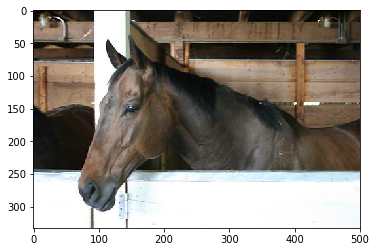

motorbike,person


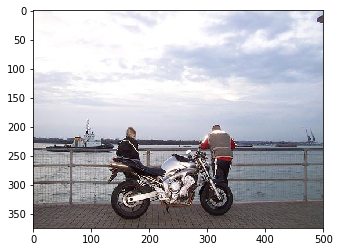

cat


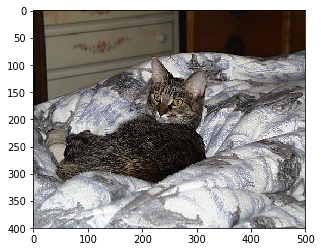

bird


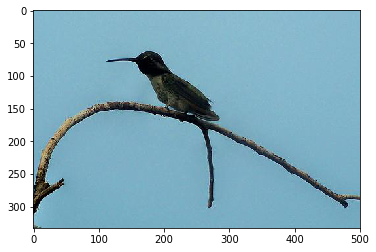

aeroplane


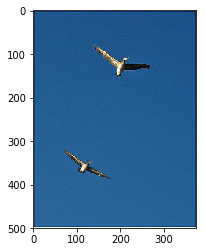

cat


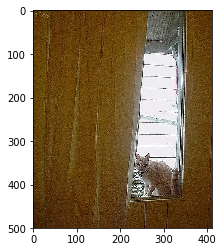

cat


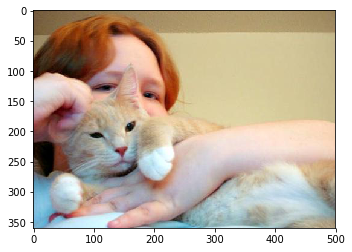

bottle,person


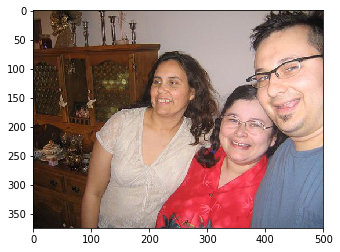

car,person


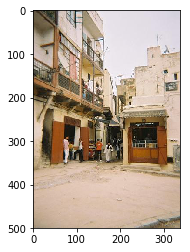

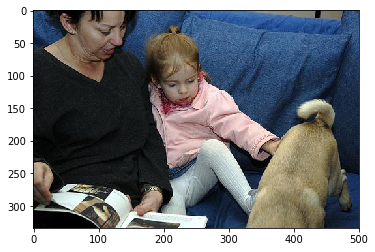

car


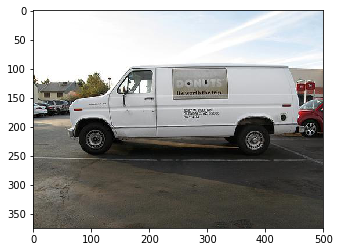

cat


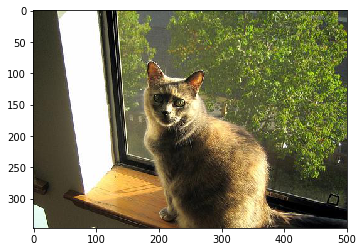

person


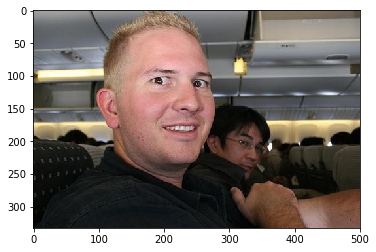

motorbike,person


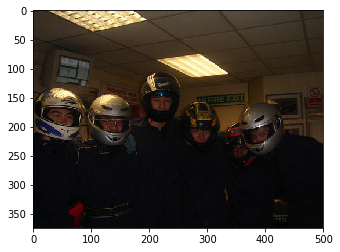

horse


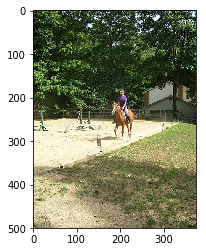

person


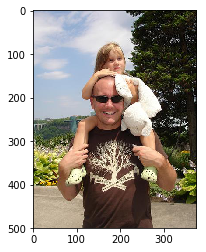

chair,person


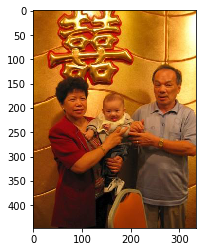

chair,sofa


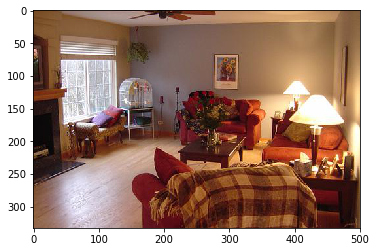

person


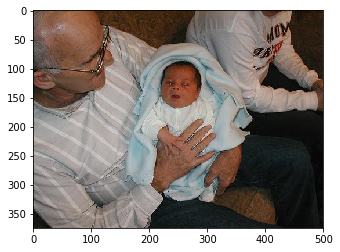

bottle,chair,diningtable,person


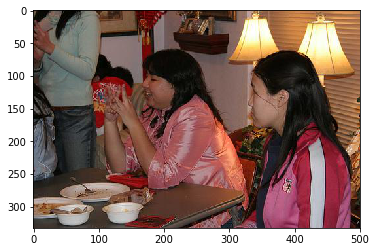

cat


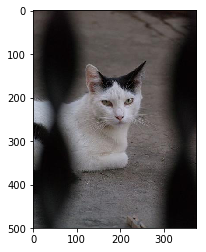

cat,person


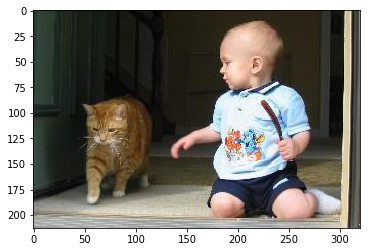

chair,person,sofa


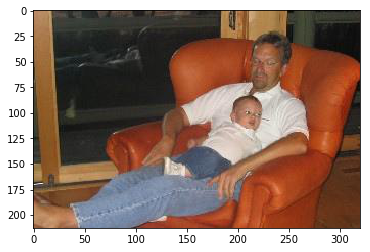

bird


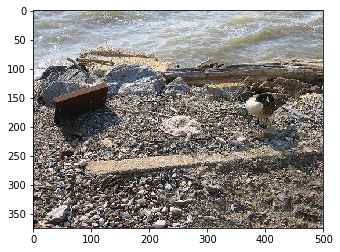

person


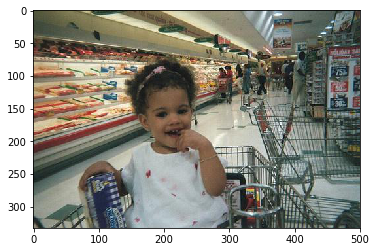

horse,person


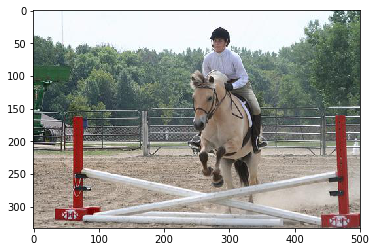

boat,person


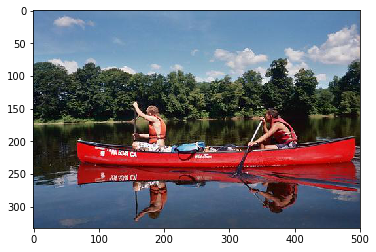

person


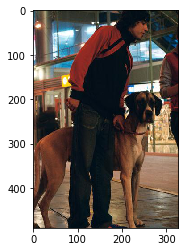

chair,person


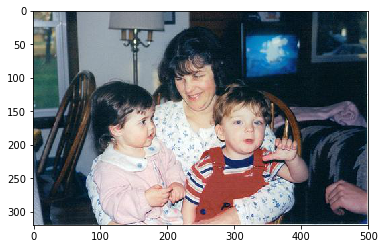

train


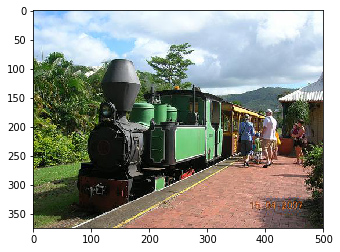

In [0]:
#Di seguito alcuni esempi

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
i=0
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
      if cls:
        l.append(labels[index])
    print(",".join(l))
    img=mpimg.imread('/content/drive/My Drive/test_splitted/' + test_generator.filenames[i])
    imgplot = plt.imshow(img)
    plt.show()
    i+=1


#Valutazione modello

In [0]:
#test_labeled.csv -> ground-truth delle immagini di test
#results_multi_label.csv -> prediction delle immagini di test

import pandas as pd

df_label = pd.read_csv('../CSV_dataset/test_labeled.csv', encoding = "ISO-8859-2")
df_pred = pd.read_csv('../CSV_risultati/results_multi_label.csv', encoding = "ISO-8859-2")



In [0]:
print(df_label.head(5))
print(df_pred.head(5))

         image                                    class
0  2008_000076  0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1  2008_000082  0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2  2008_000116  0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3  2008_000123  0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4  2008_000134  0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
      Filename                              Predictions
0  2008_000076  0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1  2008_000082  0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2  2008_000116  0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3  2008_000123  0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4  2008_000134  1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#gtruth_list e pred_list -> liste di dimensione num_images_to_test x 20 in cui una riga corrisponde ad un immagine di test e le colonne corrispondo
#alle 20 label, sempre in formato binario

gtruth_list = list()
pred_list = list()
for lb, pr in zip(df_label.iterrows(), df_pred.iterrows()):

  lb_arr = (lb[1][1].split(','))
  pr_arr = (pr[1][1].split(','))
  lb_arr = list(map(int, lb_arr))
  pr_arr = list(map(int, pr_arr))
  gtruth_list.append(lb_arr)
  pred_list.append(pr_arr)

In [0]:
#Valutazione del modello tramite le metriche 'accuracy' e 'hamming-loss'

from sklearn.metrics import hamming_loss, accuracy_score

print('Accuracy of model:')
print(accuracy_score(np.array(gtruth_list), np.array(pred_list)))
print('---------')
print('Hamming-loss of model:')
print(hamming_loss(np.array(gtruth_list), np.array(pred_list)))

Accuracy of model:
0.5244072524407253
---------
Hamming-loss of model:
0.033124128312412834


# Salvataggio modello in Google Drive

In [0]:
#Salvataggio del modello in formato json

model_json = model.to_json()
with open('model_InceptV3_final.json', 'w') as json_file:
  json_file.write(model_json)

In [0]:
#Connessione a Google Drive per poter salvare il modello

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
#Salvataggio del modello addestrato su Google Drive

model_name = 'weights_InceptV3_final.h5'
model.save_weights(model_name)

weights_file = drive.CreateFile({'title' : model_name})
weights_file.SetContentFile(model_name)
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

# Carica del modello

In [0]:
#Eseguire solamente se il file del modello in formato '.h5' è salvato su Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Caricamento del file json contenente il modello
json_file = open('../Modelli_json/model_InceptV3_multi_label.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

#Caricamento dei pesi del modello
model.load_weights(r"/content/drive/My Drive/weights_InceptV3_multi_label.h5")